# Time Series

## Using Time Series Modeling to create better predictions for 2020 and 2021

**Objective**: To use time series analysis and modeling to create a better set of predictions for what the mulfifamily housing market will look like in 2021. 

In order to do that, we need the followings steps:

1. Use time series to model values for:
    * `total_high_density_units`
    * `total_high_density_blgs`
    * `total_high_density_value`
    * `ie`
    
2. Once we have predictions, we will use `total_high_density_units` and `total_high_density_blgs` to calculate new `avg_units_per_blg`

3. We will use `avg_units_per_blg` and `ei` to predict what the clusters would look like for our new predictions. We will need to scale these two values using a Power Transformer

4. Once all this is done, we can bring in our KNN and create predictions on the new dataset.

In [1]:
# import data science libraries
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

import time_series_modeling

from math import sqrt

from sklearn import metrics
from sklearn.metrics import mean_squared_error
import sklearn

In [2]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "total_high_density_bldgs", "total_high_density_value"]
label_feature = "should_enter"

In [3]:
features_for_modeling = ["ei_x", "total_high_density_units", "total_high_density_bldgs", "total_high_density_value"]

In [23]:
df, kmeans = mo.prep_prediction_data()

In [5]:
df["city_state"] = df.city + "_" + df.state

In [6]:
unique_city_states = df.city_state.unique()

In [7]:
modeling_df = df[df.city_state == unique_city_states[5]]

## Split Data 
For practical sense - we will start by modeling only one feature. 

In [8]:
modeling_df = modeling_df[["year", "city_state", "ei_x"]]

In [9]:
modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')

In [10]:
modeling_df = modeling_df.set_index("year")

In [11]:
# Split our data

train = modeling_df[:"2015"]
validate = modeling_df["2016":"2017"]
test = modeling_df["2018":]

In [12]:
def plot_splits(train, validate, test, target_variable):
    sns.lineplot(data=train, x=train.index, y= target_variable)
    sns.lineplot(data=validate, x=validate.index, y= target_variable)
    sns.lineplot(data=test, x=test.index, y= target_variable)

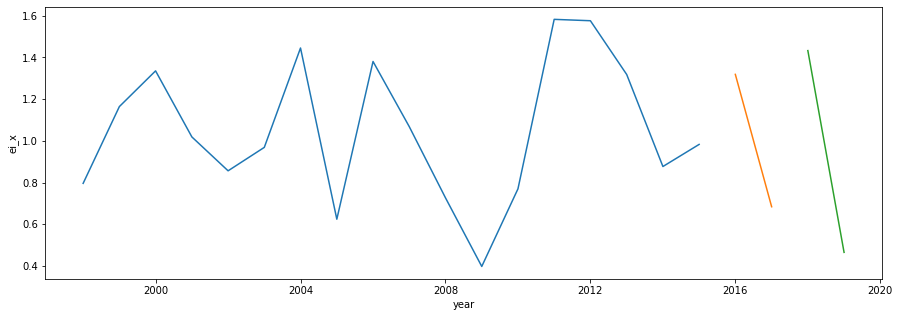

In [13]:
plt.figure(figsize=(15,5))
plot_splits(train, validate, test, target_variable="ei_x")

In [14]:
train

,city_state,ei_x
year,,
1998-01-01,Atlanta_GA,0.795989
1999-01-01,Atlanta_GA,1.164195
2000-01-01,Atlanta_GA,1.335546
2001-01-01,Atlanta_GA,1.018631
2002-01-01,Atlanta_GA,0.856185
2003-01-01,Atlanta_GA,0.968583
2004-01-01,Atlanta_GA,1.445231
2005-01-01,Atlanta_GA,0.623998
2006-01-01,Atlanta_GA,1.380533


## Modeling

In [15]:
target_variable = "ei_x"

In [16]:
predictions = time_series_modeling.create_predictions_df(train, validate, target_variable)

In [17]:
predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])

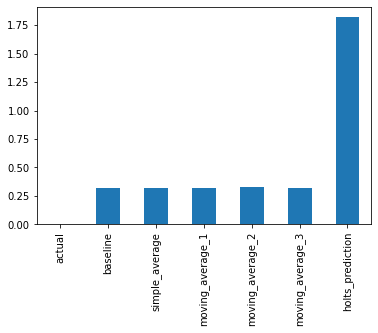

In [18]:
# Evaluate

time_series_modeling.plot_rmse(predictions)

In [62]:
rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))

In [63]:
rmse = pd.DataFrame(rmse, columns=["austin"])

In [54]:
results = pd.DataFrame()

In [66]:
results = pd.concat([rmse, results], axis = 1)

In [67]:
results

,austin,austin,austin,new_york
actual,0.000000,0.000000,NaN,0.000000
baseline,4.105206,4.105206,NaN,4.105206
simple_average,3.579520,3.579520,NaN,3.579520
moving_average_1,4.105206,4.105206,NaN,4.105206
moving_average_2,4.012748,4.012748,NaN,4.012748
moving_average_3,3.901893,3.901893,NaN,3.901893
holts_prediction,2.816334,2.816334,NaN,2.816334


In [21]:
predictions

,actual,baseline,simple_average,moving_average_1,moving_average_2,moving_average_3,holts_prediction
year,,,,,,,
2016-01-01,1.318698,0.98,1.05,0.98,0.93,1.06,2.739135
2017-01-01,0.683854,0.98,1.05,0.98,0.93,1.06,2.827545


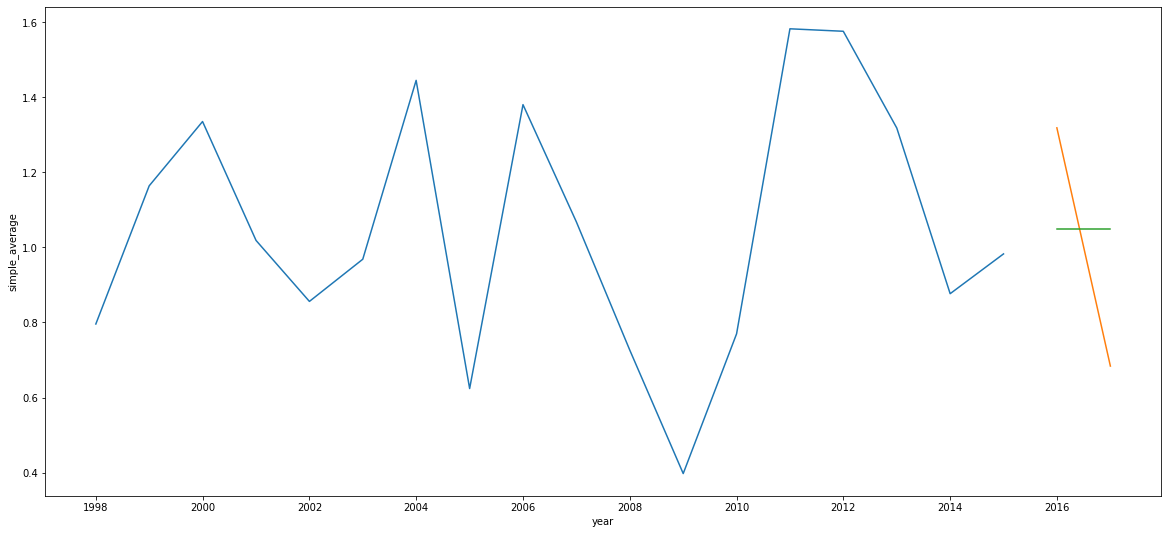

In [22]:
time_series_modeling.plot_prediction("simple_average", "ei_x", train, validate, predictions)

In [43]:
130 / 2

65.0

In [68]:
# Going to need to create a loop, and create an average rmse score to see which one would be best

results = pd.DataFrame()
updates = 0
for i in unique_city_states:
    # read data and create dataframe
    df, kmeans = mo.prep_prediction_data()
    df["city_state"] = df.city + "_" + df.state
    modeling_df = df[df.city_state == i]
    
    # Create new dataframes
    modeling_df = modeling_df[["year", "city_state", "ei_x"]]
    modeling_df.year = pd.to_datetime(modeling_df.year, format = '%Y')
    modeling_df = modeling_df.set_index("year")
    # Split our data
    train = modeling_df[:"2015"]
    validate = modeling_df["2016":"2017"]
    test = modeling_df["2018":]
    # Model
    target_variable = "ei_x"
    predictions = time_series_modeling.run_all_models(train, validate, target_variable, rolling_period = [1, 2, 3])
    # Evaluate
    rmse = predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))
    rmse = pd.DataFrame(rmse, columns=[i])
    
    results = pd.concat([rmse, results], axis = 1)

In [85]:
results

,York_PA,Worcester_MA,Wilmington_NC,Washington_DC,Tuscaloosa_AL,Tulsa_OK,Tucson_AZ,Trenton_NJ,Toledo_OH,Tampa_FL,...,Birmingham_AL,Bellingham_WA,Baltimore_MD,Austin_TX,Atlanta_GA,Appleton_WI,Anchorage_AK,Allentown_PA,Albuquerque_NM,Albany_NY
actual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
baseline,4.105206,1.652011,1.774735,0.665929,2.864555,1.058136,43.475518,0.692435,2.467644,0.310977,...,0.776304,0.111639,0.539647,0.241683,0.318135,0.437947,0.590287,0.431230,1.564790,1.715999
simple_average,3.579520,0.959803,1.386457,0.356760,2.089662,0.910135,42.671698,2.836515,1.536105,0.261566,...,1.359185,0.914284,0.555055,0.201730,0.321140,0.612019,0.378168,0.838189,1.223848,0.758062
moving_average_1,4.105206,1.652011,1.774735,0.665929,2.864555,1.058136,43.475518,0.692435,2.467644,0.310977,...,0.776304,0.111639,0.539647,0.241683,0.318135,0.437947,0.590287,0.431230,1.564790,1.715999
moving_average_2,4.012748,0.582284,1.774735,0.449141,2.514852,0.714645,43.229221,0.494694,1.425346,0.288324,...,0.776304,0.109584,0.393376,0.049735,0.325326,0.474169,1.856981,1.260292,1.692168,1.091411
moving_average_3,3.901893,0.208312,1.693530,0.492794,2.357262,0.722334,43.124104,0.419178,1.632122,0.232357,...,0.629006,0.607373,0.430209,0.049735,0.322809,0.386439,1.441572,0.873376,1.545853,0.699900
holts_prediction,2.816334,9.841038,1.287227,0.812374,2.606097,25.702893,40.307259,27.274994,3.490871,0.241103,...,0.904828,44.515346,0.359949,4.649640,1.818386,1.717449,4.812378,5.125046,3.693628,8.603365


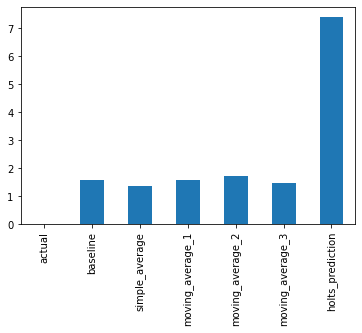

In [84]:
results.T.describe().loc["mean"].plot.bar()